In [1]:
import os,glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# **Mount Gdrive to Load Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/brain_mri/archive.zip
# unzipped only in the collab env not on drive

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

# **segregate images from the masks**

In [ ]:
image_filenames_train =[]
mask_files = glob("lgg-mri-segmentation/kaggle_3m/*/*_mask*")

for i in mask_files:
  image_filenames_train.append(i.replace('_mask',""))

print(len(image_filenames_train))
print(image_filenames_train[1])


3929
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12.tif


# **Visualise data with the mask**


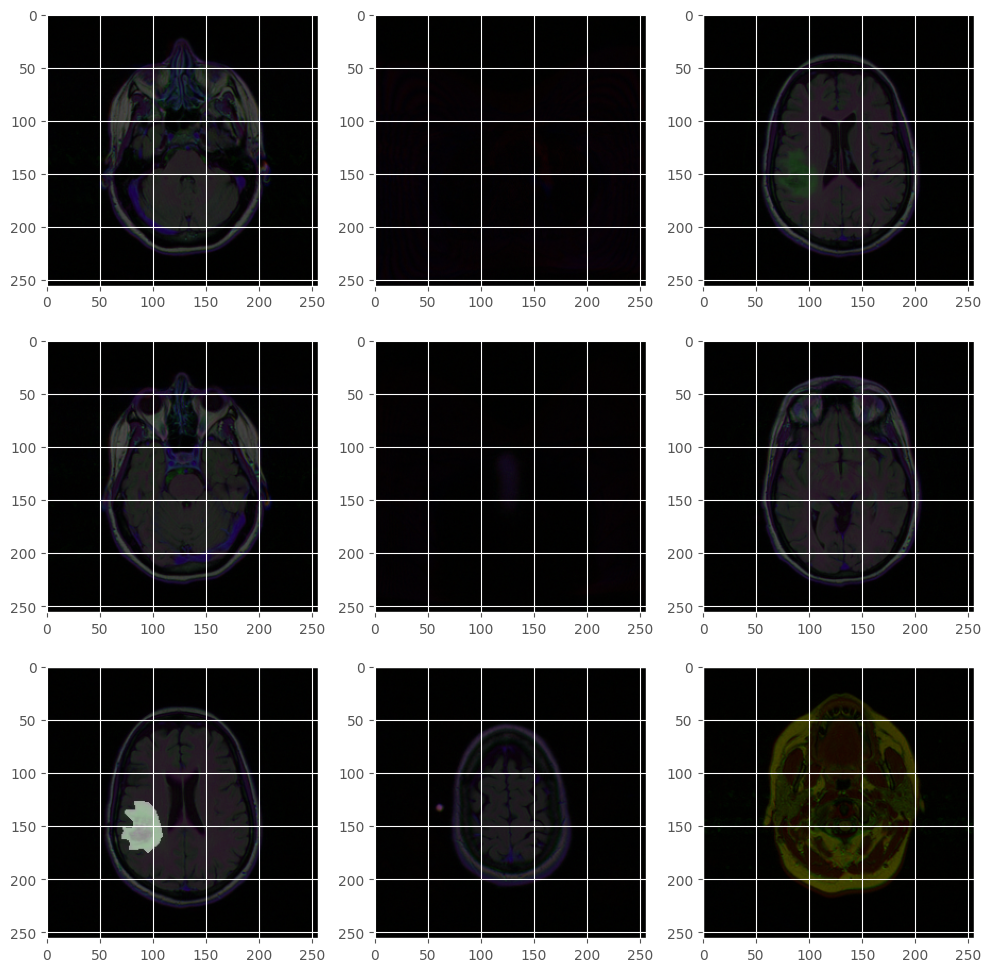

lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_46.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_25.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_14.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_19.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_26.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_35.tif
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_2.tif


In [ ]:
# plot the image as well as mask on top of it

def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
  fig = plt.figure(figsize=(12,12))
  for i in range(1, rows*columns +1 ):
    fig.add_subplot(rows, columns, i)
    img_path = list_img_path[i]
    mask_path = list_mask_path[i]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
  plt.show()

rows, cols = 3, 3
plot_from_img_path(rows, cols, image_filenames_train, mask_files)
for i in range(1,rows*cols+1):
  print(image_filenames_train[i])

 **split the data from train and test**


In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, "mask": mask_files})
# 0.9 train 0.1 test
df_train, df_test = train_test_split(df, test_size=0.1)
# 0.9*0.8 = 0.72 train  0.18 validation
df_train, df_val = train_test_split(df_train, test_size=0.2)


# **Augment the images**

In [ ]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1, #seed to reproduce results
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
im_height = 256
im_width = 256

**Instantiate the augmentation Object**

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

## **UNet architechture**

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5),conv4,],axis=3,)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3,],axis=3,)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2,],axis=3,)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1,],axis=3,)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])



In [ ]:
model = unet(input_size=(im_width,im_height,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

## **Loss metrics Definitions**

$$
\text{Intersection over Union (IoU):}
$$

$$
IoU = \frac{Intersection}{Union}
$$

$$
\text{Dice coefficient (Dice similarity coefficient or F1 score):}
$$

$$
Dice = \frac{2 \times Intersection}{\text{Sum of pixels in both masks}} \quad \text{or equivalently} \quad Dice = \frac{2 \times Intersection}{\text{Sum of pixels in predicted mask} + \text{Sum of pixels in ground truth mask}}
$$




In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou



## **Training**

In [ ]:
'''

# Define ModelCheckpoint callback to save the model to Google Drive
checkpoint_path = "/content/gdrive/MyDrive/brain_mri/ModelCheckpoint/model_{epoch:02d}.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      save_freq=10)

model.compile(optimizer=Adam(lr=1e-4), loss=dice_loss, metrics=["binary_accuracy", dice_coef, iou])

# Train the model

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback],
                    validation_data=test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

# Save the final trained model (optional, as best model will be saved by ModelCheckpoint)
final_model_path = "/content/gdrive/MyDrive/brain_mri/FinalModel/unet_brain_mri.h5"
model.save(final_model_path)

'''


'\n\n# Define ModelCheckpoint callback to save the model to Google Drive\ncheckpoint_path = "/content/gdrive/MyDrive/brain_mri/ModelCheckpoint/model_{epoch:02d}.h5"\ncheckpoint_callback = ModelCheckpoint(checkpoint_path,\n                                      save_weights_only=False,\n                                      save_freq=10)\n\nmodel.compile(optimizer=Adam(lr=1e-4), loss=dice_loss, metrics=["binary_accuracy", dice_coef, iou])\n\n# Train the model\n\nhistory = model.fit(train_gen,\n                    steps_per_epoch=len(df_train) / BATCH_SIZE,\n                    epochs=EPOCHS,\n                    callbacks=[checkpoint_callback],\n                    validation_data=test_gen,\n                    validation_steps=len(df_val) / BATCH_SIZE)\n\n# Save the final trained model (optional, as best model will be saved by ModelCheckpoint)\nfinal_model_path = "/content/gdrive/MyDrive/brain_mri/FinalModel/unet_brain_mri.h5"\nmodel.save(final_model_path)\n\n'

## Loading trained model

In [ ]:
f_model_path = "/content/gdrive/MyDrive/brain_mri/unet_brain_mri.h5"
f_model = load_model(f_model_path, custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef, 'iou': iou})

22/22 [==============================] - 11s 470ms/step - loss: 0.1549 - binary_accuracy: 0.9971 - dice_coef: 0.8187 - iou: 0.7168
Validation Loss: 0.1548643708229065
Validation Accuracy: 0.9971333742141724
Validation Dice Coefficient: 0.8187251091003418
Validation IoU: 0.7168160080909729


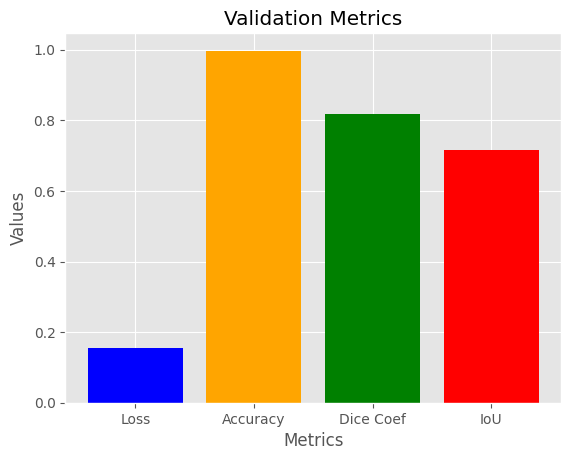

In [ ]:


# f_model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coef, iou])
val_loss, val_accuracy, val_dice_coef, val_iou = f_model.evaluate(test_gen, steps=len(df_val) / BATCH_SIZE)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Dice Coefficient:", val_dice_coef)
print("Validation IoU:", val_iou)

# Plot the metrics (assuming you have access to validation metrics)
plt.bar(['Loss', 'Accuracy', 'Dice Coef', 'IoU'], [val_loss, val_accuracy, val_dice_coef, val_iou], color=['blue', 'orange', 'green', 'red'])
plt.title('Validation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()



# **Test the prediction of the Model**

1/1 [==============================] - 4s 4s/step


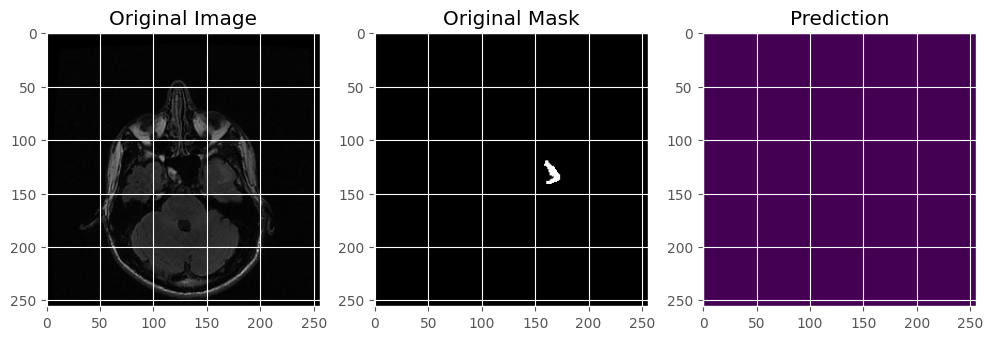

1/1 [==============================] - 0s 20ms/step


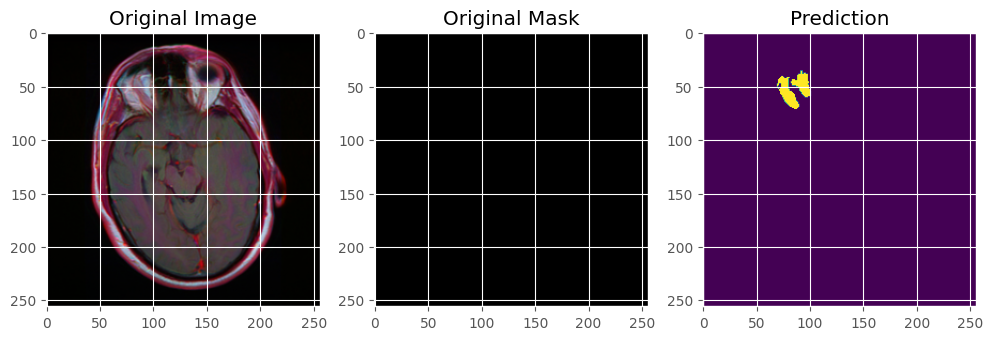

1/1 [==============================] - 0s 21ms/step


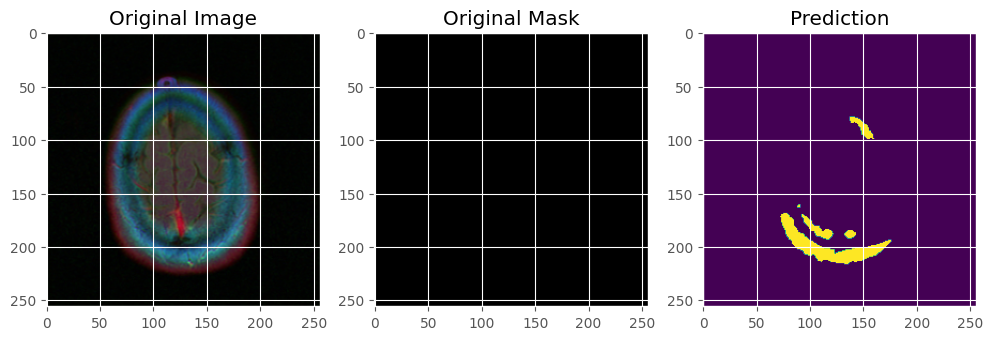

1/1 [==============================] - 0s 21ms/step


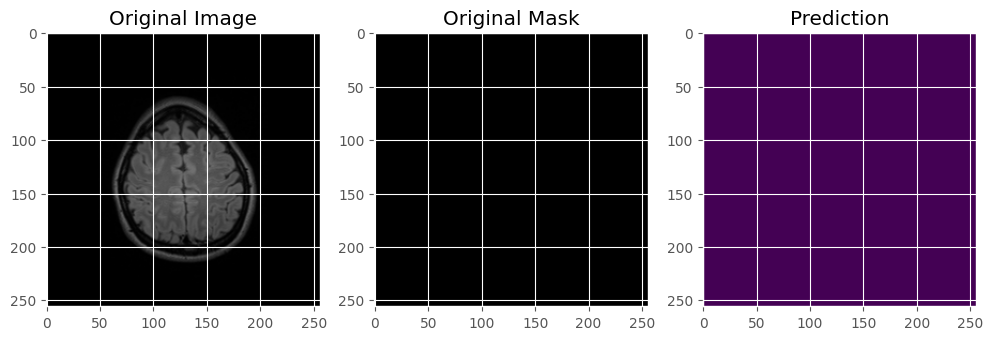

1/1 [==============================] - 0s 28ms/step


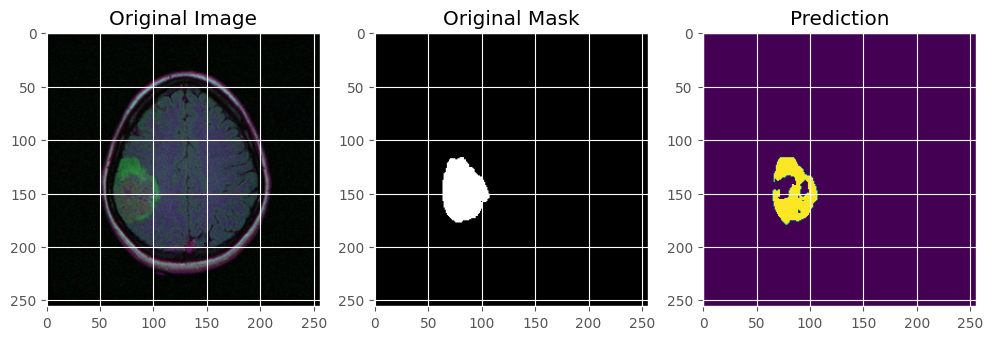

1/1 [==============================] - 0s 38ms/step


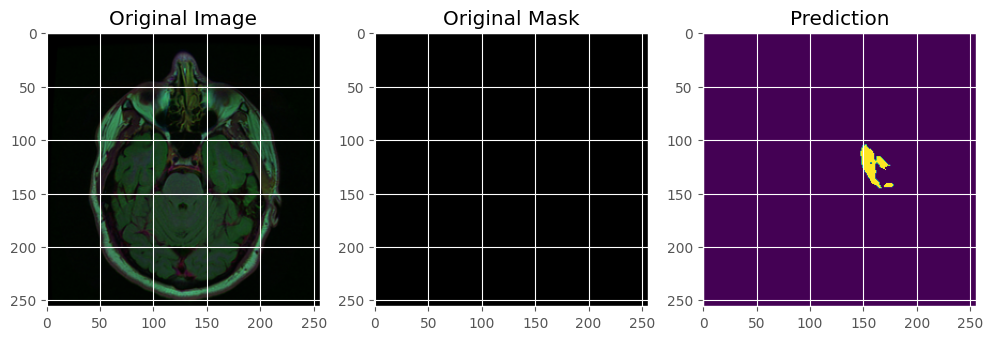

1/1 [==============================] - 0s 33ms/step


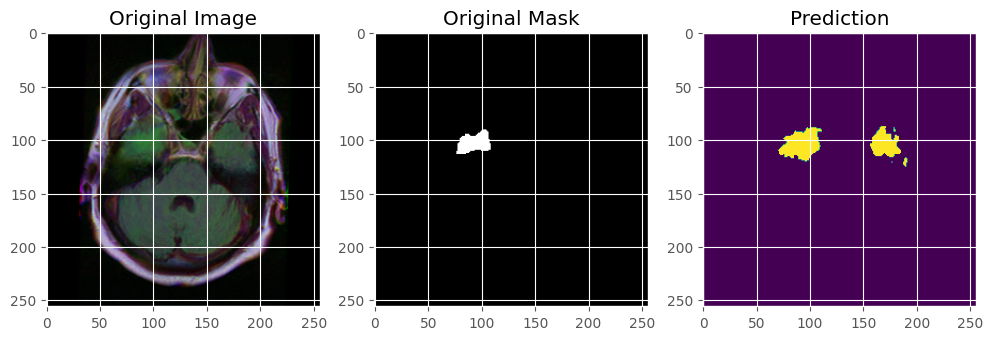

1/1 [==============================] - 0s 33ms/step


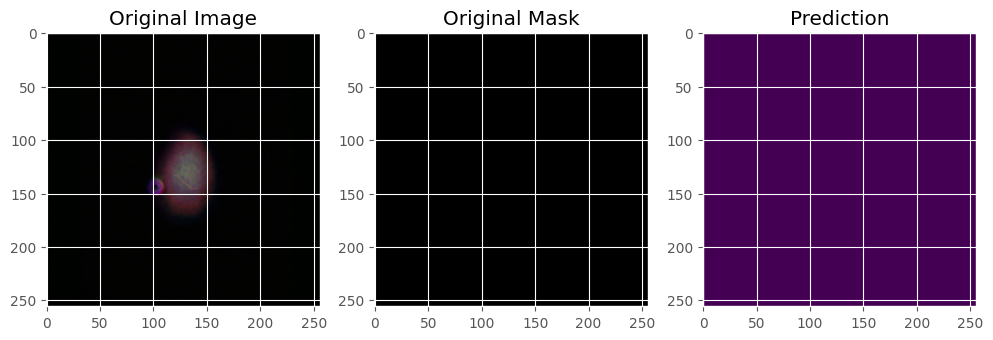

1/1 [==============================] - 0s 31ms/step


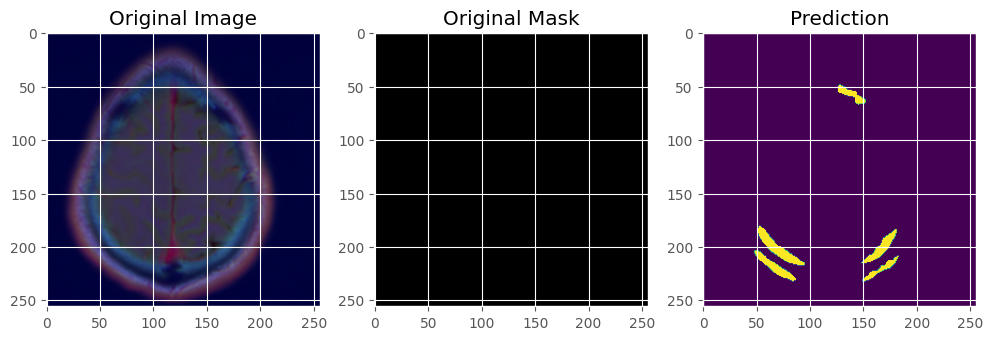

1/1 [==============================] - 0s 20ms/step


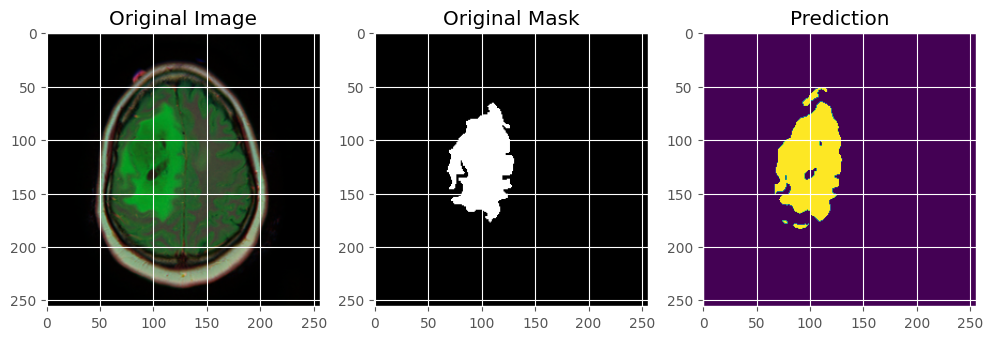

1/1 [==============================] - 0s 19ms/step


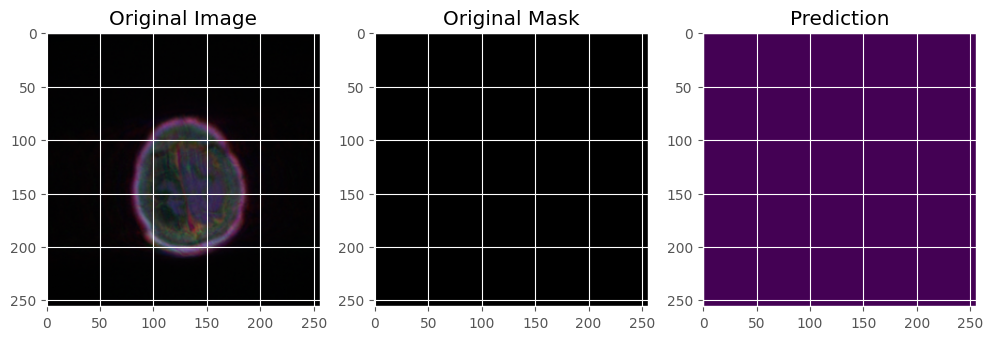

1/1 [==============================] - 0s 19ms/step


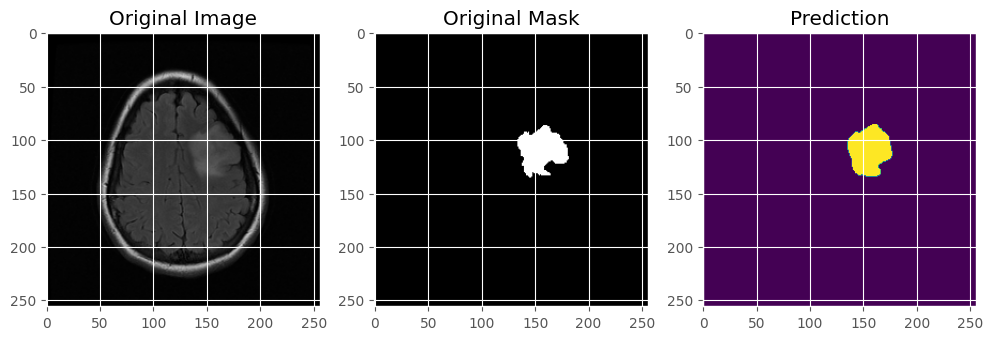

1/1 [==============================] - 0s 31ms/step


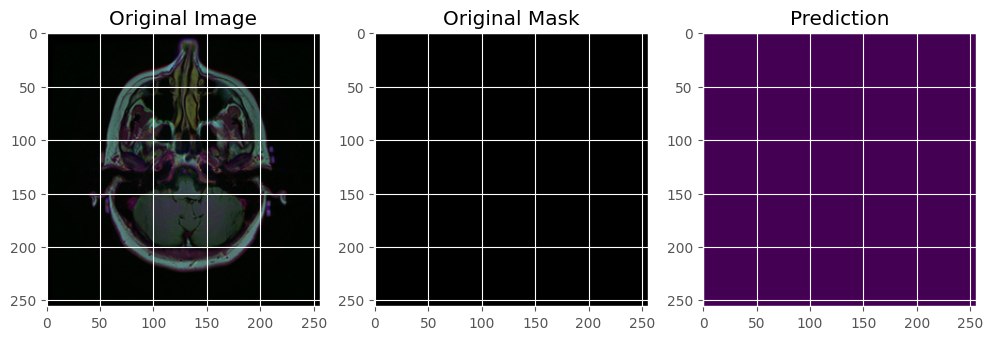

1/1 [==============================] - 0s 19ms/step


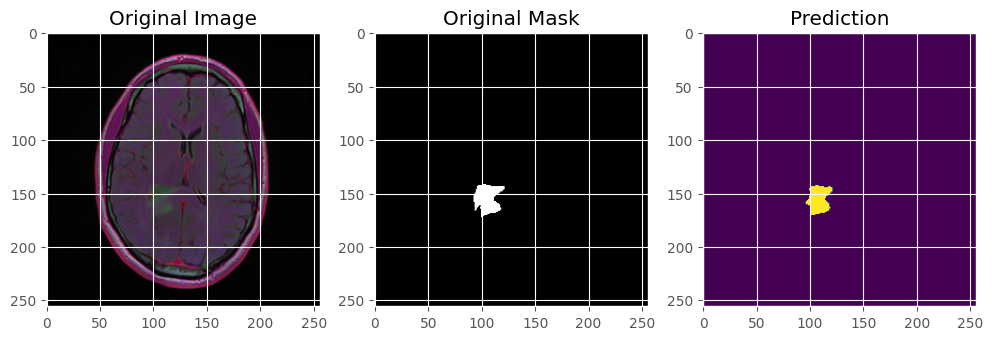

1/1 [==============================] - 0s 21ms/step


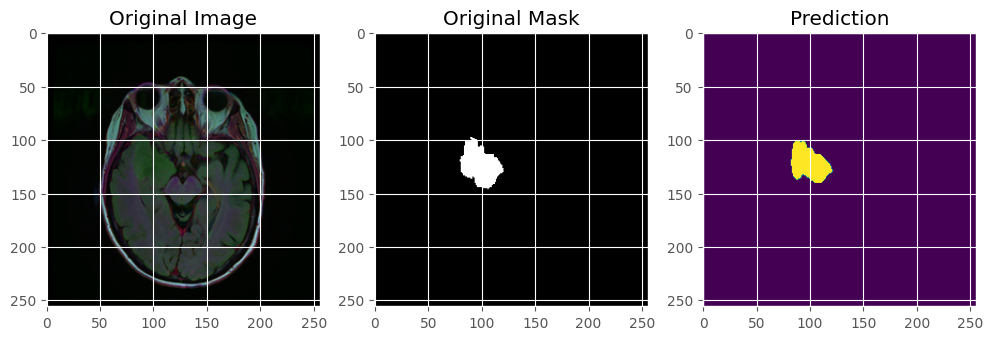

1/1 [==============================] - 0s 19ms/step


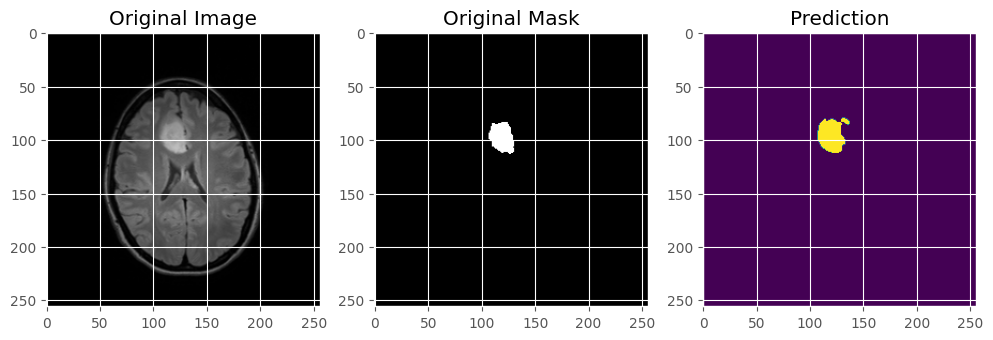

1/1 [==============================] - 0s 19ms/step


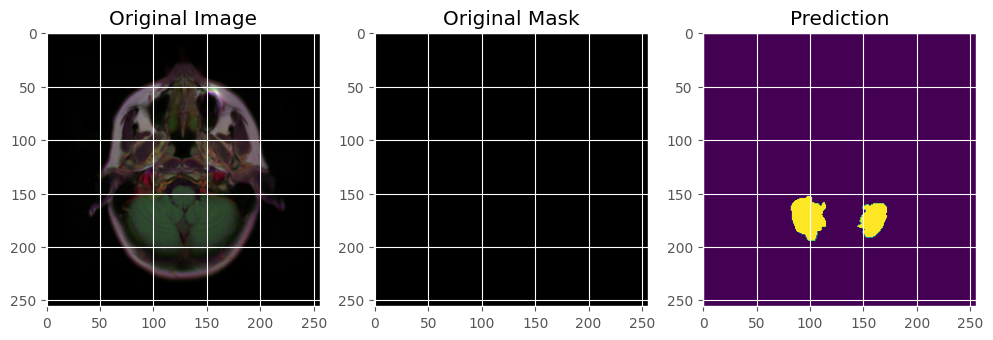

1/1 [==============================] - 0s 21ms/step


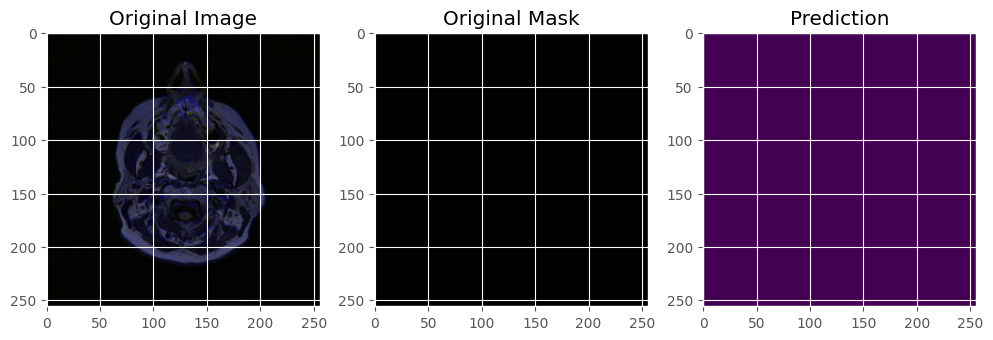

1/1 [==============================] - 0s 19ms/step


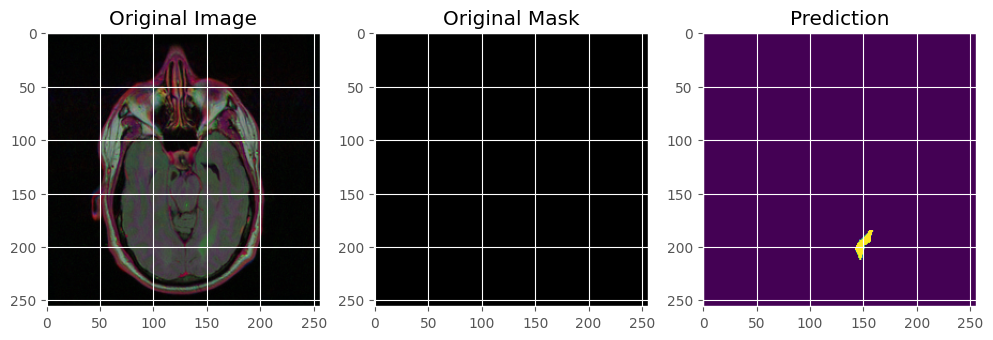

1/1 [==============================] - 0s 24ms/step


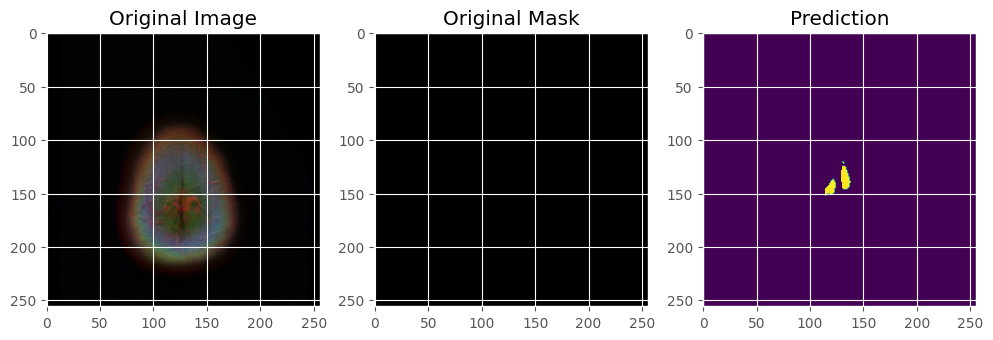

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = f_model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()